# Introduction to Geostatistics

These examples and exercises are based on the ML-PREP Lecture notes [01_geostat.pdf](https://github.com/markasch/ML-PREP-2025/blob/main/02GeoDataScience/geostatistics/01_geostat.pdf)

We will cover the following topics:

- stochastic processes
- covariance, correlation and variograms
- kriging (`pykrige` examples are in a separate notebook)

## Notation

In this notebook, we mix 2 notations for stochasic processes:

- $X_t$ or $X(t)$ for a process that is indexed by time, or evolves in time,
- $Z_x$ or $Z(x)$ for a spatially dependent process, usually called a random field.

The theory is indifferent to the notation and is, of course, valid for both cases - time-dependent and space-dependent. We also suppress the dependence on the sampling or the realization, denoted by $\omega \in \Omega,$  the space of all possible outcomes of the random process.

---

## Stochastic Processes and Random Fields

We start with the definition and a simulation of the classical stochastic process, Brownian motion.

### Gaussian Random Variable

A Gaussian random variable is a random variable $X$  with probability density function
$$
  f_X(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left[ - \frac{(x - \mu)^2}{2 \sigma^2 }  \right],
$$

where $(\mu,\sigma^2)$ are the mean and variance of the distribution. We write

$$
  X \sim \mathcal{N}(\mu,\sigma^2).
$$


## Brownian Motion

Brownian motion, or a Wiener process, on the interval $[0, T]$ is a random variable $W(t)$ that depends continuously on time $t \in [0, T]$ and whose increments, $W(t)-W(\tau),$ follow a Gaussian distribution with mean zero and variance equal to the time lag, $t - \tau.$ That is

$$
  W(t)-W(\tau) \sim \sqrt{t-\tau }\; \mathcal{N}(0, 1).
$$

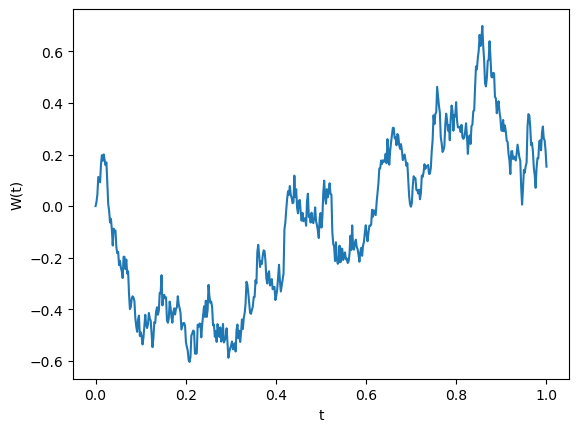

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# time interval and time-step
T = 1
N = 500
dt = T/N
t = np.linspace(0,1,N)
# initialize
dW = np.zeros(N)
W  = np.zeros(N)
# first step
np.random.seed(42)
dW[0] = np.sqrt(dt)*np.random.randn()
W[0]  = dW[0]
# loop over time
for j in range(N-1):
    dW[j+1] = np.sqrt(dt)*np.random.randn()
    W[j+1]  = W[j] + dW[j+1]
# plot the BM path
plt.plot(t,np.append([0], W[1:N]))
plt.xlabel('t'); plt.ylabel('W(t)')
plt.show()

## Mean and Covariance of a Stochastic Process

The mean function $\mu_X (t)$ of a random function $X(t)$ is
$$
  \mu_X (t) = \mathrm{E}\, [X(t)].
$$

Recall that the variance of a random variable, $X,$ is

$$
    \sigma^2 =  \mathrm{Var}\,[X] =  \mathrm{E}\, [ (X - \mu)^2] = \mathrm{E}\, [X^2] - \mu^2,
$$
and that the covariance of two random variables, $X$ and $Y,$ is
$$
\begin{align*}
\mathrm{Cov}\, \left[X,Y\right]  =\sigma_{XY} = & \mathrm{E}\, \left[(X-\mu_{X})(Y-\mu_{Y})\right]\\
= & \mathrm{E}\, \left[XY\right]-\mu_{X}\mu_{Y}
\end{align*}
$$

Then, the cross-covariance function is defined for a pair of random processes $X(t)$ and  $Y(t)$ as
$$
  C_{X,Y} (t_1,t_2) =  \mathrm{E}\, [ (X(t_1) - \mu_X(t_1))\, (Y(t_2) - \mu_Y(t_2))] = \mathrm{Cov}\, [X(t_1),Y(t_2)]
$$

and the autocovariance function  of the random process $X(t)$ is
$$
\begin{align}
   C_{X} (t_1,t_2) &=  \mathrm{E}\, [ (X(t_1) - \mu_X(t_1))\, (X(t_2) - \mu_X(t_2))] \\
                   &= R_X (t_1,t_2) - \mu_X(t_1) \mu_X(t_2),
\end{align}
$$

where the autocorrelation function is defined as
$$
  R_X (t_1,t_2) = \mathrm{E}\, [ X(t_1) X(t_2) ].
$$

---

### Example of Mean Function

Suppose $A \sim \mathcal{U}[0,1]$ is a uniform random variable in the interval $[0,1],$  and suppose that we have a stochastic process (random function)
$$
   Z(x) = A \cos 2\pi x.
$$

First we calculate, and then we will simulate its mean function $\mu_Z (x).$ Verify that
$$
 \mathrm{E}\, [ Z(x) ] = 0.5 \cos 2\pi x.
$$

Here is the simulation.

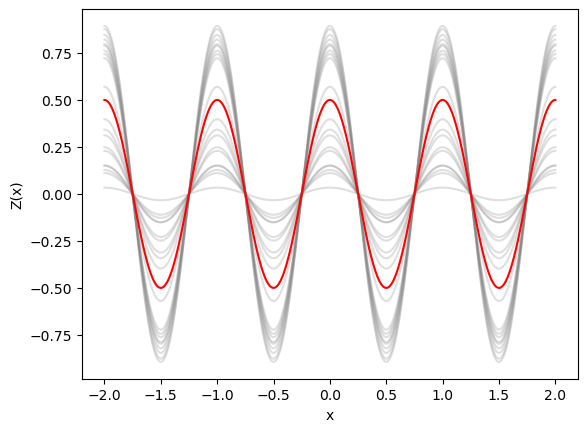

In [10]:
M = 20  # number of realizations
z = np.zeros((1000,M))
x = np.linspace(-2,2,1000)
for i in range(M):
  z[:,i] = np.random.rand(1)*np.cos(2*np.pi*x)
plt.plot(x,z,color='gray', alpha=0.25)
plt.plot(x,0.5*np.cos(2*np.pi*x),color='red')
plt.xlabel('x')
plt.ylabel('Z(x)')
plt.show()

### Example of Autocorrelation Function

Suppose that we have the same random field,
$$
   Z(x) = A \cos 2\pi x,
$$

with $A \sim \mathcal{U}[0,1].$ We calculate (please verify!) the autocorrelation function for any 2 points $x_1,$ $x_2$  
$$
  R_Z (x_1, x_2) = \frac{1}{3} \cos (2\pi x_1) \,  \cos (2\pi x_2).
$$

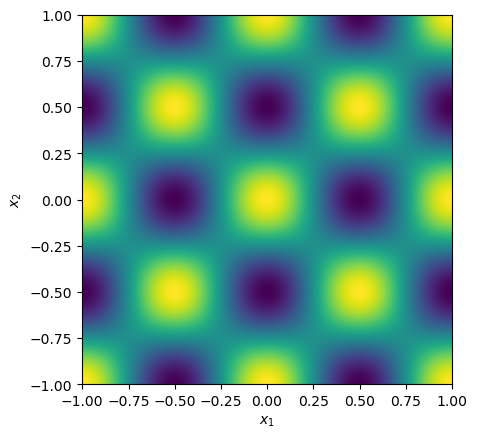

In [17]:
x1 = np.linspace(-1,1,1000)
x2 = np.linspace(-1,1,1000)
R = (1/3)*np.outer(np.cos(2*np.pi*x1), np.cos(2*np.pi*x2))
plt.imshow(R, extent=[-1, 1, -1, 1])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

To understand and interpret this autocorrelation, we fix any two spatial points $x_1$ and $x_2$ to produce two random variables $Z_1 = Z(x_1)$ and  $Z_2 = Z(x_2).$ The joint expectation $\mathrm{E}\, [ Z(x_1) Z(x_2) ] $ will give a single value (recall that expectation is an integral over $x$ - or a sum for discrete-valued random variables) in the 2D function $R_Z(x_1,x_2).$ This value quantifies the correlation between $Z(x_1)$ and $Z(x_2),$  and by varying $x_1$ and $x_2$ over a domain $D,$ we can map all the spatial dependencies of the attribute $Z.$ This is an essential operation in geospatial data analysis.

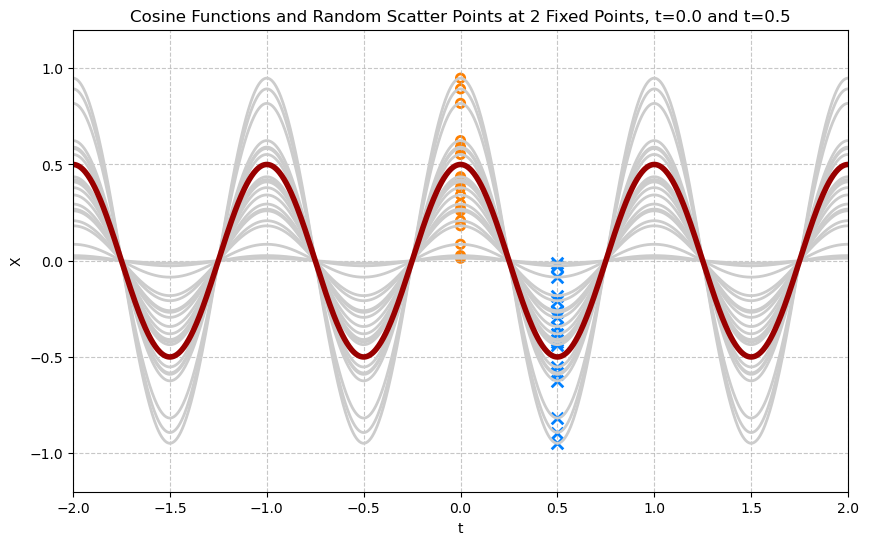

In [24]:
# Plot the time (space) function for
#      t = 0, t = 0.5
# to visualize random process at 2 fixed points
# that produce a single point in the 2D autocorrelation 
#      R[X(0), X(0.5)] = E [X(0) X(0.5)]

# Define the time vector
t = np.linspace(-2, 2, 1000)

# Generate X matrix with random scaling
X = np.zeros((len(t), 20))
for i in range(20):
    X[:, i] = np.random.rand() * np.cos(2 * np.pi * t)

# Plot each column of X with light gray color
plt.figure(figsize=(10, 6))
for i in range(20):
    plt.plot(t, X[:, i], linewidth=2, color=[0.8, 0.8, 0.8])

# Plot the main cosine function
plt.plot(t, 0.5 * np.cos(2 * np.pi * t), linewidth=4, color=[0.6, 0, 0])

# Scatter points at t=0 (index 501 in the t vector)
plt.scatter(
    np.zeros(20), X[500, :], 
    linewidths=2, edgecolors=[1, 0.5, 0], facecolors='none'
)

# Scatter points at t=0.5 (index 626 in the t vector)
plt.scatter(
    np.full(20, 0.5), X[625, :], 
    marker='x', linewidths=2, s=70, color=[0, 0.5, 1]
)

# Configure grid, ticks, and axes
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(-2, 2.5, 0.5))
plt.axis([-2, 2, -1.2, 1.2])

# Add labels and title
plt.xlabel('t')
plt.ylabel('X')
plt.title('Cosine Functions and Random Scatter Points at 2 Fixed Points, t=0.0 and t=0.5')

plt.show()

### Example of a Weakly Stationary Process

Recall (see lecture notes) that weakly stationary processes play an important role in geostatistics, in particular for kriging.

Consider the random function 
$$
  X(t) = \cos (\omega t + \theta),
$$

where $ \theta \sim  \mathcal{U}[-\pi,\pi].$

First, we compute its mean function,

$$
\begin{align}
  \mu_X(t) &=  \mathrm{E}\, [ \cos (\omega t + \theta) ] \\
           &= \int_{-\pi}^{\pi} \cos (\omega t + \theta) \cdot \frac{1}{2\pi} \; \mathrm{d}\theta \\
           &= 0.
\end{align}
$$

The first condition for weak stationarity is verified. Now, let us calculate the autocorrelation function,
$$
\begin{align}
  R_X (t_1, t_2) &= \mathrm{E}\, [ \cos (\omega t_1 + \theta) \cos (\omega t_2 + \theta) ] \\
                 &=   \frac{1}{2\pi}  \int_{-\pi}^{\pi} \cos (\omega t_1 + \theta) \cos (\omega t_2 + \theta) \; \mathrm{d}\theta  \\
                 &=  \frac{1}{2} \cos (\omega (t_1 - t_2) ). 
\end{align}
$$

The last line is obtained using the trigonometric identity for the product of 2 cosine functions (please check this!). 

We observe that the covariance/correlation depends only on the increment/lag $\tau = t_1 - t_2,$ so we have fulfilled the 2 conditions for weak (wide-sense) stationarity:

- constant, know mean
- autocorrelation (or autocovariance) depending only on the distance between 2 points.

Recall the relation between autocovariance and autocorrelation,
$$
  C_X(t_1, t_2) =  R_X (t_1, t_2) - \mu^2 .
$$

Thus, weak stationarity can be expressed in terms of either.


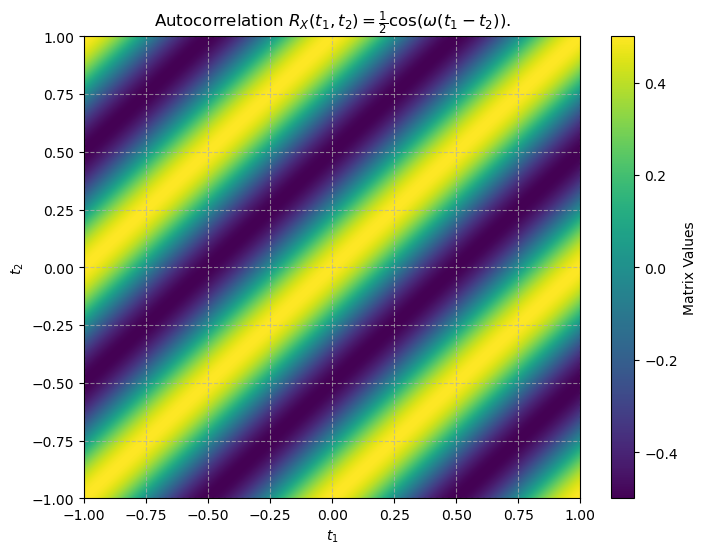

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

# Define the time vector
t = np.linspace(-1, 1, 1000)

# Create the Toeplitz matrix
R = toeplitz(0.5 * np.cos(2 * np.pi * t))

# Plot the matrix
plt.figure(figsize=(8, 6))
plt.imshow(R, extent=[-1, 1, -1, 1], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Matrix Values')
plt.grid(True, linestyle='--', alpha=0.7)

# Set x and y ticks
plt.xticks(np.arange(-1, 1.25, 0.25))
plt.yticks(np.arange(-1, 1.25, 0.25))

# Add labels
plt.xlabel(r'$t_1$')
plt.ylabel(r'$t_2$')
plt.title(r'Autocorrelation $ R_X (t_1, t_2) = \frac{1}{2} \cos (\omega (t_1 - t_2) ).  $')

plt.show()

As in the previous example, we can compute the mean function, plot realizations and show two random variables, $X(t_1)$ and $X(t_2$ to visualize the correlation.

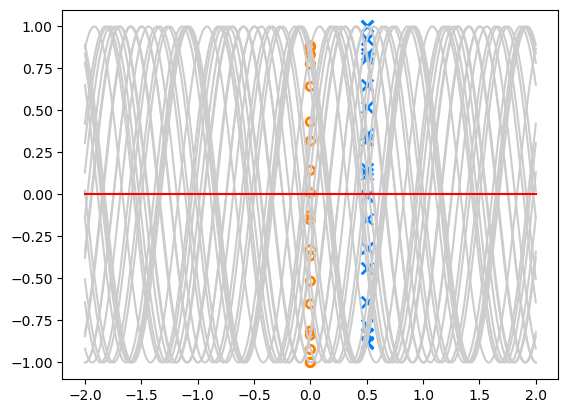

In [30]:
x = np.zeros((1000,20))
t = np.linspace(-2,2,1000)
for i in range(20):
  Theta = 2*np.pi*(np.random.rand(1))
  x[:,i] = np.cos(2*np.pi*t+Theta)
plt.plot(t,x,color=[0.8, 0.8, 0.8])
plt.plot(t,np.zeros((1000,1)),color='red')
# Scatter points at t=0 (index 501 in the t vector)
plt.scatter(
    np.zeros(20), x[500, :], 
    linewidths=2, edgecolors=[1, 0.5, 0], facecolors='none'
)
# Scatter points at t=0.5 (index 626 in the t vector)
plt.scatter(
    np.full(20, 0.5), x[625, :], 
    marker='x', linewidths=2, s=70, color=[0, 0.5, 1]
)
plt.show()

To visualize the stationary character of $R,$  we plot 3 cross-sections of $R_X (t_1, t_2)$ for $t_2 = -0.18,0.0,0.3 .$ Clearly, each curve is just a shift of the other, and  only depends on the lag $\tau = t_1 - t_2.$ It suffices to know the red curve, and then all other values of $R_X$ can be deduced from it.

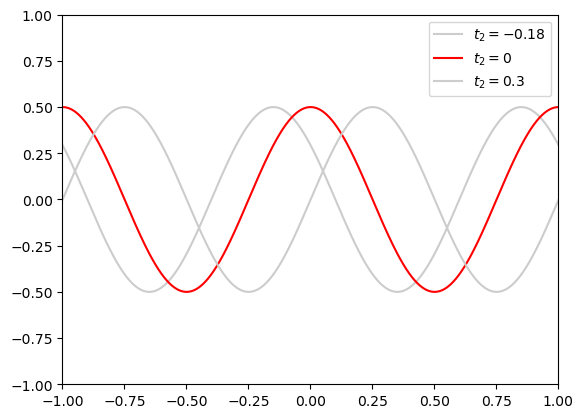

In [45]:
t = np.linspace(-1, 1, 1000)
plt.plot(t,R[425, :],color=[0.8, 0.8, 0.8])
plt.plot(t,R[500, :],color='red')
plt.plot(t,R[625, :],color=[0.8, 0.8, 0.8])
plt.axis([-1, 1, -1, 1])
plt.legend([r'$t_2 = -0.18$', r'$t_2 = 0$', r'$t_2 = 0.3$'])
plt.show()

---

## Variograms

A variogram is a function that describes how the similarity between data points changes as the distance between them increases. This similarity — or rather, the lack of it — is known as spatial autocorrelation. The basic principle is that things closer together are more alike than further apart, a concept known as Tobler’s First Law of Geography. The variogram provides a quantitative means to model this relationship. See the [Lecture Notes](https://github.com/markasch/ML-PREP-2025/blob/main/02GeoDataScience/geostatistics/01_geostat.pdf) for more details.

<img src="Schematic_variogram.svg" alt="Variogram" width="800"/>

A variogram plots the variance of the difference between data points against their distance. The resulting curve offers three key insights:

- Nugget: This refers to the variance at minimal distances, showing any micro-scale variation or measurement error.
- Sill: The sill is where the variogram flattens, indicating that increasing distance no longer increases variance — beyond this point, the data points are no longer correlated.
- Range: The range defines the distance where the variogram reaches the sill, representing the limit of spatial correlation between data points.

Variograms are essential for working with spatial interpolation techniques like kriging. In many fields — whether predicting soil properties for agriculture, modeling rainfall for climate research, or mapping pollution levels in urban environments — variograms are the foundation that helps you understand spatial dependencies before applying any predictive model. Without a variogram, your spatial model risks being inaccurate or even misleading.

Constructing a variogram is relatively straightforward, especially with the right geostatistical tools. 

1. First, you calculate the differences between each pair of points in your spatial dataset.
2. Then, plot these differences against the distance between points.
3. This empirical variogram is the starting point for fitting a theoretical model, such as spherical, exponential, or Gaussian models.

We will use the `GSTools` package.

> `conda install gstools`



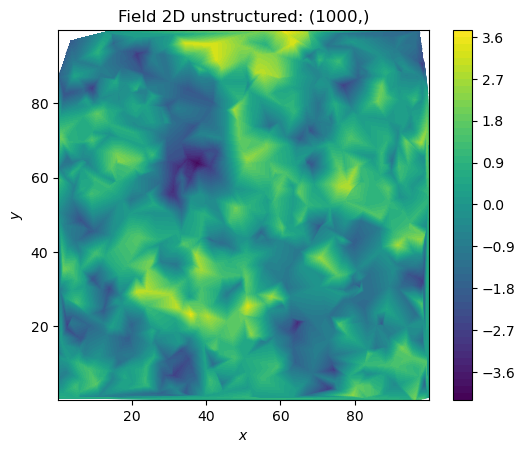

In [6]:
import gstools as gs
import numpy as np

# Generate a synthetic random field with an exponential model.
x = np.random.RandomState(19970221).rand(1000) * 100.0
y = np.random.RandomState(20011012).rand(1000) * 100.0
model = gs.Exponential(dim=2, var=2, len_scale=8)
srf = gs.SRF(model, mean=0, seed=19970221)

# Visualize the field
field = srf((x, y))
srf.vtk_export("field")
ax = srf.plot()
ax.set_aspect("equal")

Stable(dim=2, var=1.92, len_scale=8.15, nugget=0.0, alpha=1.05)


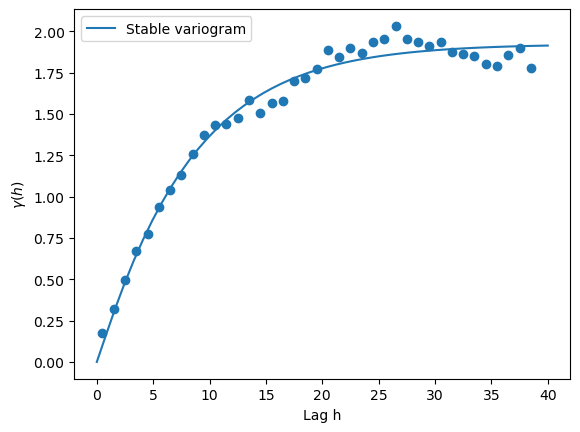

In [12]:
# Estimate the empirical variogram of the field with 40 bins.
bins = np.arange(40)
bin_center, gamma = gs.vario_estimate((x, y), field, bins)

# Fit the variogram with a stable model, no nugget fitted.
fit_model = gs.Stable(dim=2)
fit_model.fit_variogram(bin_center, gamma, nugget=False)

# Plot the result of the fit, together with the empirical variogram
ax = fit_model.plot(x_max=40)
ax.scatter(bin_center, gamma)
ax.set_xlabel('Lag h')
ax.set_ylabel(r'$\gamma(h)$')
print(fit_model)

### Finding the best Variogram fit

As seen in the [Lecture Notes](https://github.com/markasch/ML-PREP-2025/blob/main/02GeoDataScience/geostatistics/01_geostat.pdf), there are numerous parametric variogram models available. To choose the best model, we fit each type, and then compute the $R^2$ score to rank the models.

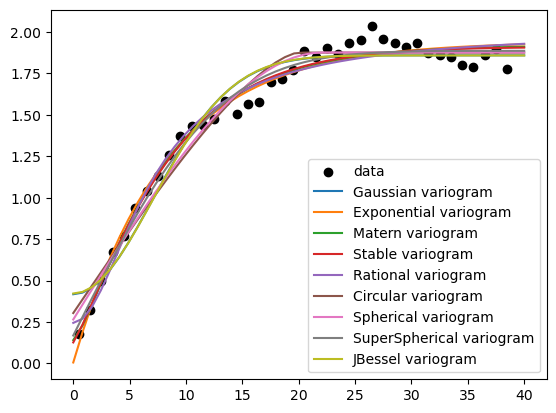

In [14]:
import matplotlib.pyplot as plt
# Define the set of models to test
models = {
    "Gaussian": gs.Gaussian,
    "Exponential": gs.Exponential,
    "Matern": gs.Matern,
    "Stable": gs.Stable,
    "Rational": gs.Rational,
    "Circular": gs.Circular,
    "Spherical": gs.Spherical,
    "SuperSpherical": gs.SuperSpherical,
    "JBessel": gs.JBessel,
}
scores = {}

## Plot the estimated variogram
plt.scatter(bin_center, gamma, color="k", label="data")
ax = plt.gca()

#  Loop over the models, fit each model to the estimated variogram, and compute the R2 score
for model in models:
    fit_model = models[model](dim=2)
    para, pcov, r2 = fit_model.fit_variogram(bin_center, gamma, return_r2=True)
    fit_model.plot(x_max=40, ax=ax)
    scores[model] = r2

In [16]:
# Create a ranking based on the score and determine the best models
ranking = sorted(scores.items(), key=lambda item: item[1], reverse=True)
print("RANKING by Pseudo-r2 score")
for i, (model, score) in enumerate(ranking, 1):
    print(f"{i:>6}. {model:>15}: {score:.5}")

RANKING by Pseudo-r2 score
     1.          Stable: 0.98218
     2.          Matern: 0.98176
     3.  SuperSpherical: 0.98141
     4.     Exponential: 0.98041
     5.        Rational: 0.97711
     6.       Spherical: 0.97334
     7.        Circular: 0.96725
     8.        Gaussian: 0.95928
     9.         JBessel: 0.95831


**Conclusion**: the stable model produces the best fit, in terms of $R^2,$ though it is only marginally better than the Matérn model, which is considered to be the most accurate in a large numeber of cases.

---

## Kriging


### Ordinary kriging

Here is a very simple example of Ordinary Kriging to estimate the value of an attribute at a single point, $x.$

The OK implemented here uses an exponential variogram model and a matrix approach to calculate the variance between sample points and the point of interest.

Additional examples are in separate notebook: [02geostat_KRIGING.ipynb](02geostat_KRIGING.ipynb)

In [46]:
import numpy as np

# Sample coordinates
coords = np.array([
    [2, 3],  # Point A
    [2, 1],  # Point B
    [1, 2],  # Point C
    [3, 2]   # Point D
])

# sample values
values = np.array([37, 36, 38, 35])

# Point of interest "X"
point_x = np.array([2, 2])

# Exponential variogram parameters
C0 = 0
C = 6
a = 300

# function Exponential variogram
def variogram_exponential(h, C0, C, a):
    return C0 + C * (1 - np.exp(-h / a))

# Euclidean distance
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

# Assemble the variance matrix
n = len(coords)
gamma = np.zeros((n+1, n+1))
for i in range(n):
    for j in range(n):
        h = euclidean_distance(coords[i], coords[j])
        gamma[i, j] = variogram_exponential(h, C0, C, a)

# Additional terms for the OK matrix
gamma[:-1, -1] = 1
gamma[-1, :-1] = 1
gamma[-1, -1] = 0

# Variance vector between point "X" and samples
gamma_x = np.zeros(n+1)
for i in range(n):
    h = euclidean_distance(coords[i], point_x)
    gamma_x[i] = variogram_exponential(h, C0, C, a)
gamma_x[-1] = 1

# Solve the system of equations
weights = np.linalg.solve(gamma, gamma_x)

# Estimate the value at point "X"
Z_x = np.sum(weights[:-1] * values)

# Show results
print(f"Variance matrix (gamma):")
print(gamma)
print("\nVariance vector (gamma_x):")
print(gamma_x)
print(f"\nPoint estimation X: {Z_x}")

Variance matrix (gamma):
[[0.         0.03986696 0.02821771 0.02821771 1.        ]
 [0.03986696 0.         0.02821771 0.02821771 1.        ]
 [0.02821771 0.02821771 0.         0.03986696 1.        ]
 [0.02821771 0.02821771 0.03986696 0.         1.        ]
 [1.         1.         1.         1.         0.        ]]

Variance vector (gamma_x):
[0.0199667 0.0199667 0.0199667 0.0199667 1.       ]

Point estimation X: 36.5


### Example of Simple Kriging

Even though it is rarely applicable in practice, simple kriging is a good introduction to the more general ordinaty and universal krigin methods.

W
Recall: with known mean, the SK system to be solved is
$$
\begin{split}W = \begin{pmatrix}c(x_1,x_1) & \cdots & c(x_1,x_n) \\
\vdots & \ddots & \vdots  \\
c(x_n,x_1) & \cdots & c(x_n,x_n)
\end{pmatrix}^{-1}
\begin{pmatrix}c(x_1,x_0) \\ \vdots \\ c(x_n,x_0) \end{pmatrix},\end{split}
$$

where $c(x_i,x_j)$ is the covariance of the given observations.

Suppose we have 5 observations, and we perform simple kriging in 1D, which is easier to visulaize.

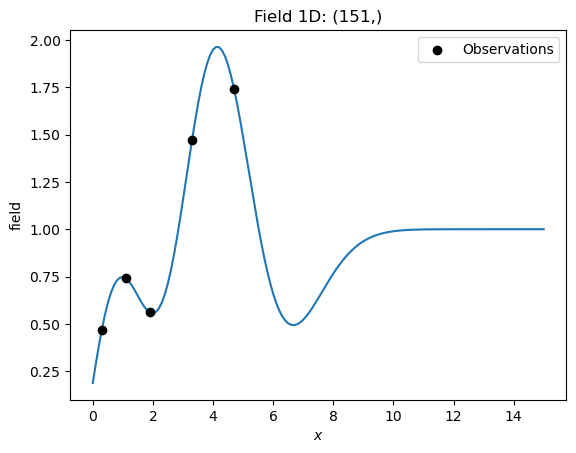

In [23]:
from gstools import Gaussian, krige

# Observaions: positions and values
obs_pos = [0.3, 1.9, 1.1, 3.3, 4.7]
obs_val = [0.47, 0.56, 0.74, 1.47, 1.74]
# resulting grid
gridx = np.linspace(0.0, 15.0, 151)
# spatial, Gaussian random field 
model = Gaussian(dim=1, var=0.5, len_scale=2)
# simple kriging, with mean=1
krig = krige.Simple(model, mean=1, cond_pos=obs_pos, cond_val=obs_val)
krig(gridx)
# plot results
ax = krig.plot()
ax.scatter(obs_pos, obs_val, color="k", zorder=10, label="Observations")
ax.legend()
plt.show()